In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import delay_embedding as embed
import worm_dynamics as worm_dyn
import make_trajectories as mt
import stats
import clustering_methods as cl
from sklearn.linear_model import LinearRegression
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [2]:
mat=h5py.File(dir_path+'Foraging/ForagingData/PNAS2011-DataStitched.mat','r')

refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

import worm_dynamics as worm_dyn
segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

f = h5py.File(dir_path+'Foraging/ForagingData/phspace_K_10_m_7.h5','r')
traj_matrix = ma.array(f['traj_matrix'])
phspace = ma.array(f['phspace'])
components = np.array(f['modes'])
f.close()

n_clusters=1000
f = h5py.File(dir_path+'Foraging/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters))
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

In [15]:
import scipy.io
mat = scipy.io.loadmat(dir_path+'Foraging/ForagingData/wormCentroid.mat')
X_worm,Y_worm = mat['cmX'],mat['cmY']

centroids_w = []
for kw in range(X_worm.shape[0]):
    centroids_w.append(np.vstack([X_worm[kw,::2],Y_worm[kw,::2]]).T)
    
all_centroids = ma.vstack(centroids_w)

In [16]:
from scipy.signal import savgol_filter, general_gaussian

window_length=33
poly_order = 3
deriv = 0
delta = 1/frameRate

X_w = []
for X in centroids_w:
    X_smooth = savgol_filter(X, window_length=window_length, polyorder=poly_order, deriv=deriv, delta=delta,axis=0)
    X_smooth = ma.masked_invalid(X_smooth)
    X_smooth[0] = ma.masked
    X_smooth[-1] = ma.masked
    X_w.append(X_smooth)
    
centroids_smooth = ma.vstack(X_w)

In [5]:
delay = int(.75*frameRate)
print(delay)
# delay=13
lcs,P = op_calc.transition_matrix(labels_traj,delay,return_connected=True)
final_labels = op_calc.get_connected_labels(labels_traj,lcs)
n_modes=10
inv_measure = op_calc.stationary_distribution(P)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(eigvals)

eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

phi2 = eigfunctions[:,1]

12


In [6]:
c_range,rho_sets,idx,kmeans_labels = op_calc.optimal_partition(phi2,inv_measure,P,return_rho=True)

In [7]:
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

In [8]:
def MSD_unc(x, lags=500, exclude=None):
    if exclude is None:
        exclude = np.zeros(x.shape[0])
    exclude = np.cumsum(exclude.astype(int))

    if type(lags) is int:
        lags = np.arange(lags)
    mu = ma.zeros((len(lags),))
    Unc = ma.zeros((len(lags),))
    Unc.mask=True
    for i, lag in enumerate(lags):
        if lag==0:
            mu[i] = 0
            Unc[0]=len(x[:,0].compressed())
        elif lag >= x.shape[0]:
            mu[i] = ma.masked
        else:
            x0 = x[lag:,:].copy()
            x1 = x[:-lag,:].copy()
            reject = (exclude[lag:]-exclude[:-lag])>0
            x0[reject,:] = ma.masked
            x1[reject,:] = ma.masked
            displacements = ma.sum((x0 - x1)**2,axis=1)
            mu[i] = displacements.mean()
            Unc[i]=len(displacements.compressed())
    return mu,Unc 

In [17]:
len_w = len(tseries_w[0])
worm_idx = 8

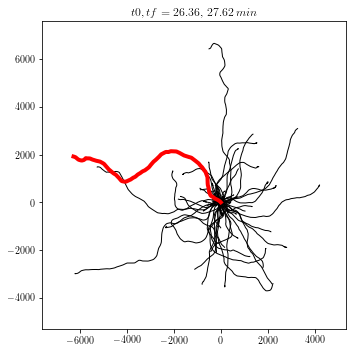

In [18]:
mask = cluster_traj_all[t0:tf]==1
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
plt.figure(figsize=(5,5))
for t_0,t_f in segments:
    X_here = ma.vstack(X_w)[t0+t_0:t0+t_f]-ma.vstack(X_w)[t0+t_0]
    plt.plot(X_here[:,0],X_here[:,1],c='k',alpha=1,lw=1)
# plt.show()
idx = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1][2]
t_0_run,t_f_run = segments[idx]
# print(segments[idx]*dt/60)
plt.xlim(-7600,5300)
plt.ylim(-5300,7600)
 
plt.title(r'$t0,tf = {:.2f},\,{:.2f}\,min$'.format(segments[idx][0]*dt/60,segments[idx][1]*dt/60))
X_here = ma.vstack(X_w)[t0+t_0_run:t0+t_f_run]-ma.vstack(X_w)[t0+t_0_run]
plt.plot(X_here[:,0],X_here[:,1],lw=4,c='r')
# plt.axis('equal')
plt.tight_layout()
# plt.savefig('run_trajectories_worm_{}.pdf'.format(worm_idx))
plt.show()



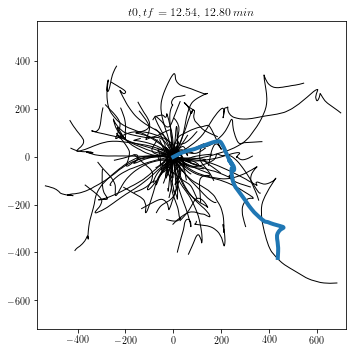

In [19]:
mask = cluster_traj_all[t0:tf]==0
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
plt.figure(figsize=(5,5))
for t_0,t_f in segments:
    X_here = ma.vstack(X_w)[t0+t_0:t0+t_f]-ma.vstack(X_w)[t0+t_0]
    plt.plot(X_here[:,0],X_here[:,1],c='k',alpha=1,lw=1)
# plt.show()
idx = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1][0]
t_0_pir,t_f_pir = segments[idx]
# plt.ylim(-600,400)
# print(segments[idx]*dt/60)
plt.title(r'$t0,tf = {:.2f},\,{:.2f}\,min$'.format(segments[idx][0]*dt/60,segments[idx][1]*dt/60))
X_here = ma.vstack(X_w)[t0+t_0_pir:t0+t_f_pir]-ma.vstack(X_w)[t0+t_0_pir]
plt.plot(X_here[:,0],X_here[:,1],lw=4)
plt.xlim(-570,720)
plt.ylim(-720,570)


# plt.axis('equal')
plt.tight_layout()
# plt.savefig('pirouette_trajectories_worm_{}_zoomin.pdf'.format(worm_idx))
plt.show()

In [20]:
n_rows = 50
cluster_mat_2states = ma.repeat(cluster_traj_all,n_rows).reshape(cluster_traj_all.shape[0],n_rows)

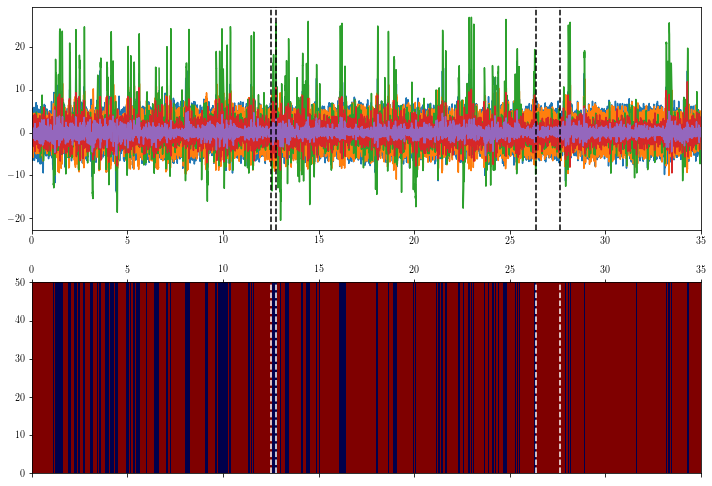

In [21]:
plt.figure(figsize=(10,7))
t0,tf = worm_idx*len_w,(worm_idx+1)*len_w
# print(t0,tf)
# print(ma.vstack(tseries_w))
plt.subplot(2,1,1)
plt.plot(np.arange(0,35,dt/60),ma.vstack(tseries_w)[t0:tf])
plt.xlim(0,35)
plt.xticks(np.array(np.linspace(0,35,8),dtype=int))
plt.axvline(t_0_run*dt/60,ls='--',c='k')
plt.axvline(t_f_run*dt/60,ls='--',c='k')
plt.axvline(t_0_pir*dt/60,ls='--',c='k')
plt.axvline(t_f_pir*dt/60,ls='--',c='k')

plt.subplot(2,1,2)
plt.matshow(cluster_mat_2states[t0:tf,:].T,aspect=.2,extent=(0,35,0,50),cmap='seismic',fignum=0)#,vmax=1.2,vmin=-.2)
plt.axvline(t_0_run*dt/60,ls='--',c='w')
plt.axvline(t_f_run*dt/60,ls='--',c='w')
plt.axvline(t_0_pir*dt/60,ls='--',c='w')
plt.axvline(t_f_pir*dt/60,ls='--',c='w')
plt.tight_layout()
# plt.savefig('tseries_2state_labels_worm_{}.pdf'.format(worm_idx))
plt.show()

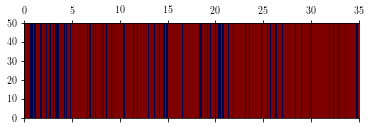

In [22]:
f = h5py.File(dir_path+'Foraging/ForagingData/symbol_sequence_simulations.h5','r')
sims_example_w = np.array(f['8/sims'],dtype=int)
# print(list(f['MetaData/delay']))
f.close()

n_rows = 50
cluster_traj_sim = kmeans_labels[sims_example_w][7]
cluster_mat_sim = ma.repeat(cluster_traj_sim,n_rows).reshape(cluster_traj_sim.shape[0],n_rows)
plt.matshow(cluster_mat_sim[:,:].T,aspect=.2,extent=(0,35,0,50),cmap='seismic',fignum=0)#,vmax=1.2,vmin=-.2)
# plt.savefig('example_sim_labels.pdf')
plt.show()

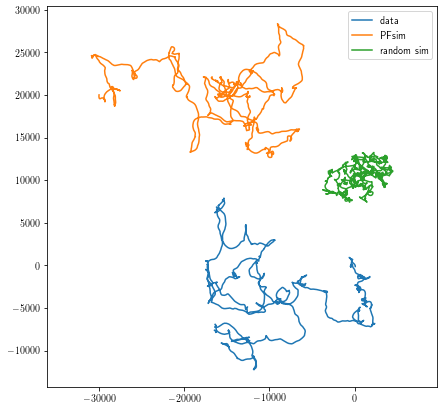

In [23]:
plt.figure(figsize=(7,7))
worm_idx=3
plt.plot(X_w[worm_idx][:,0],X_w[worm_idx][:,1],label='data')

k=94
f = h5py.File(dir_path+'Foraging/ForagingData/trajectory_simulations.h5','r')
PF_group = f['PF_sim'][str(worm_idx)]
full_traj_sim = ma.array(PF_group[str(k)])
f.close()
plt.plot(full_traj_sim[:,0]-30000,full_traj_sim[:,1]+20000,label='PFsim')


k=99
f = h5py.File(dir_path+'Foraging/ForagingData/trajectory_simulations.h5','r')
random_group = f['random_sim'][str(worm_idx)]
full_traj_random_sim = ma.array(random_group[str(k)])
f.close()
plt.plot(full_traj_random_sim[:,0],full_traj_random_sim[:,1]+10000,label='random sim')
plt.legend()
plt.axis('equal')
# plt.savefig('example_trajs_sims.pdf')
plt.show()

# Compute MSD 

In [25]:
new_frameRate = frameRate/delay
new_dt = 1/new_frameRate
min_t = 50
max_t = 100
lags = np.arange(0,int(200*new_frameRate),int(np.ceil(new_frameRate)))

In [26]:
n_worms=12
len_w = 33600

n_sims = 100

m_data_w = []
m_sims_w = []
msd_sims_w = []
msd_data_w = []

for worm_idx in range(n_worms):
    t0,tf = worm_idx*len_w,(worm_idx+1)*len_w
    cluster_traj = cluster_traj_all[t0:tf][::delay]
    X = X_w[worm_idx][::delay]

    mu_data,Unc_data = MSD_unc(ma.array(X),lags=lags)

    x = (lags[min_t:max_t]*new_dt).reshape(-1,1)
    y = mu_data[min_t:max_t]
    w = Unc_data[min_t:max_t]
    reg = LinearRegression(fit_intercept=True).fit(x, y,sample_weight = w)
    m_data = reg.coef_[0]
    
    msd_data_w.append(mu_data)
    m_data_w.append(m_data)

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
0 5.33986684873326 5.253613893696376 4.841266908361126


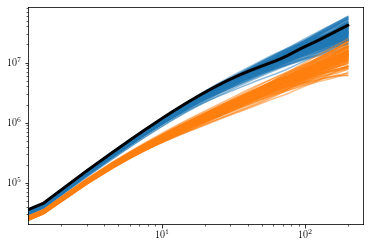

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
1 6.070018343873067 5.814635907570439 5.121121417122365


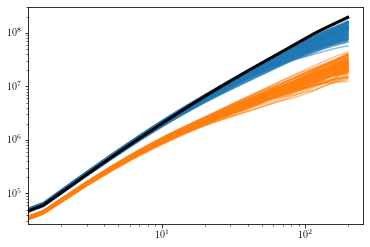

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
2 5.281654562918538 5.1309055316186445 4.331931053109134


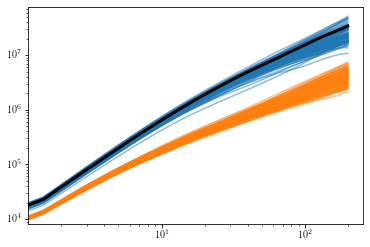

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
3 5.352168737256693 5.381010948326189 4.7244718258727945


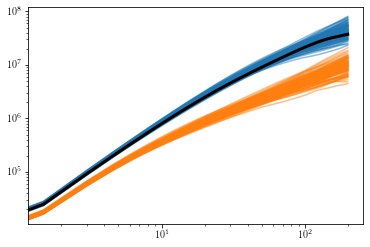

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
4 5.5618614102765465 5.444804121562805 4.508466959824026


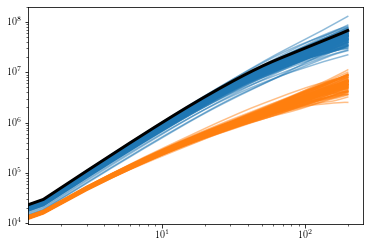

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
5 4.857744115679528 4.700079532283523 4.043756630864418


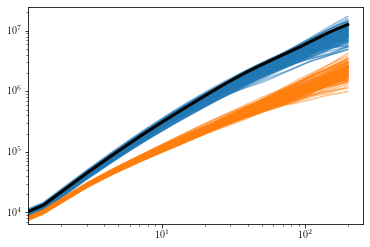

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
6 5.111083870096706 5.104172940062147 4.508653812583027


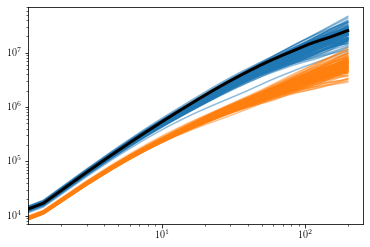

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
7 5.318917508922884 5.368335741880652 5.044790184422363


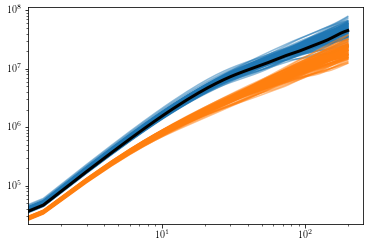

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
8 5.1239615009387 5.2562997956595785 4.608879199239028


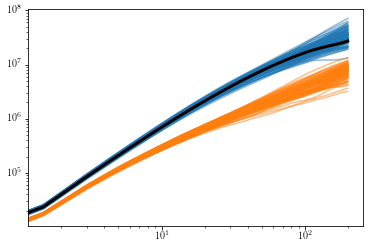

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
9 5.197809364466927 5.242940338044135 4.712647351643336


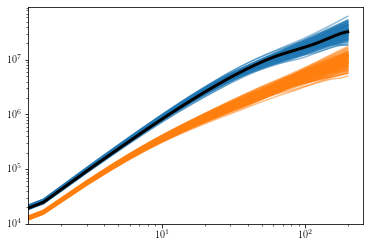

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
10 5.478159801589537 5.268346810269503 4.517039066327369


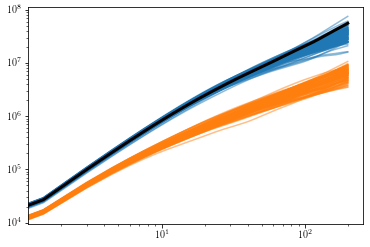

[12.]
0
10
20
30
40
50
60
70
80
90
[12.]
0
10
20
30
40
50
60
70
80
90
11 4.858435955049748 4.97796951079101 5.09809492225763


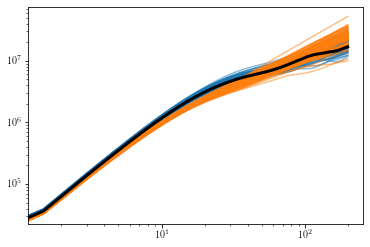

In [27]:
m_sims_PF_w = []
msd_sims_PF_w = []
m_sims_random_w = []
msd_sims_random_w = []
for worm_idx in range(n_worms):
    
    mu_data = msd_data_w[worm_idx]
    m_data = m_data_w[worm_idx]
    
    f = h5py.File(dir_path+'Foraging/ForagingData/trajectory_simulations.h5','r')
    print(np.array(f['MetaData/delay']))
    PF_group = f['PF_sim'][str(worm_idx)]
    
    m_sims = np.zeros(n_sims)
    msd_sims = []
    for k in np.arange(n_sims):
        full_traj_sim = ma.array(PF_group[str(k)])
        mu,Unc = MSD_unc(ma.array(full_traj_sim),lags=lags)
        x = (lags[min_t:max_t]*new_dt).reshape(-1,1)
        y = mu[min_t:max_t]
        w = Unc[min_t:max_t]
        reg = LinearRegression(fit_intercept=True).fit(x, y,sample_weight = w)
        m_sim = reg.coef_[0]
        m_sims[k] = m_sim
        msd_sims.append(mu)
        if k%10==0:
            print(k)
            
    f.close()
    
    m_sims_PF_w.append(m_sims)
    msd_sims_PF_w.append(msd_sims)

    
    f = h5py.File(dir_path+'Foraging/ForagingData/trajectory_simulations.h5','r')
    print(np.array(f['MetaData/delay']))
    random_group = f['random_sim'][str(worm_idx)]
    
    m_random_sims = np.zeros(n_sims)
    msd_random_sims = []
    for k in np.arange(n_sims):
        full_traj_random_sim = ma.array(random_group[str(k)])
        mu,Unc = MSD_unc(ma.array(full_traj_random_sim),lags=lags)
        x = (lags[min_t:max_t]*new_dt).reshape(-1,1)
        y = mu[min_t:max_t]
        w = Unc[min_t:max_t]
        reg = LinearRegression(fit_intercept=True).fit(x, y,sample_weight = w)
        m_sim = reg.coef_[0]
        m_random_sims[k] = m_sim
        msd_random_sims.append(mu)
        if k%10==0:
            print(k)
            
    m_sims_random_w.append(m_random_sims)
    msd_sims_random_w.append(msd_random_sims)
    
    print(worm_idx,np.log10(m_data),np.log10(np.mean(m_sims)),np.log10(np.mean(m_random_sims)))
    
    for msd in msd_sims:
        plt.plot(lags*new_dt,msd,c=colors_state_[0],alpha=.5)
    for msd in msd_random_sims:
        plt.plot(lags*new_dt,msd,c=colors_state_[1],alpha=.5)
    plt.plot(lags*new_dt,mu_data,lw=3,c='k')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

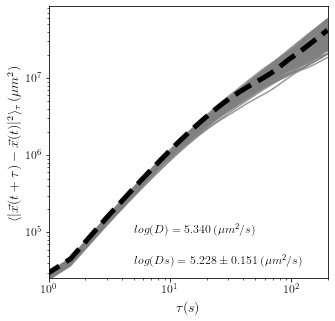

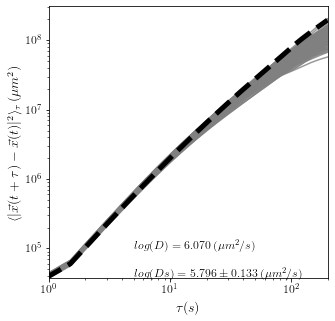

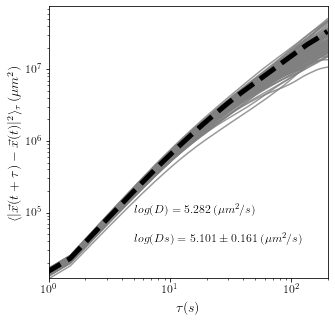

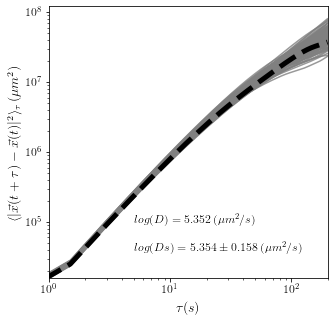

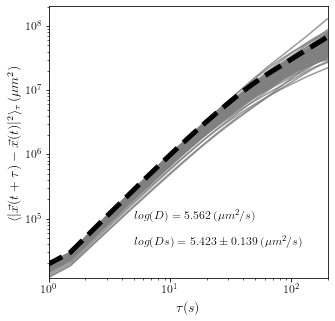

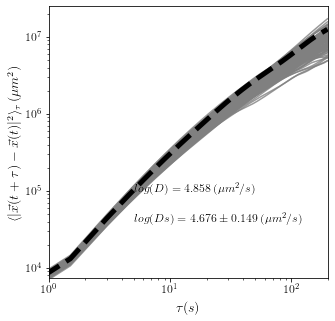

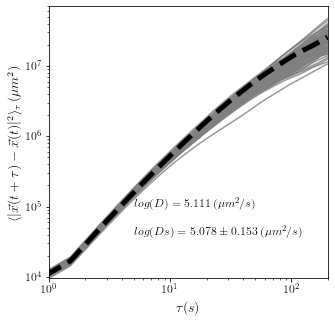

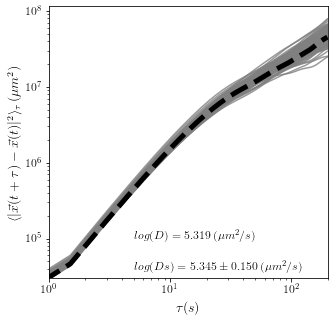

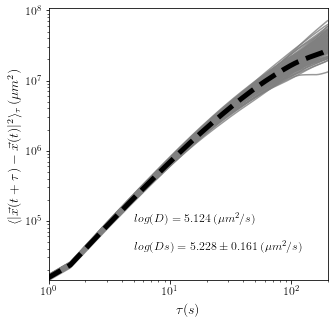

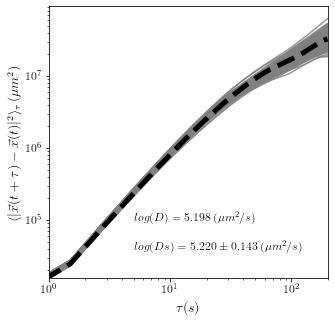

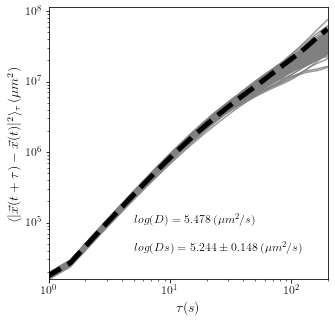

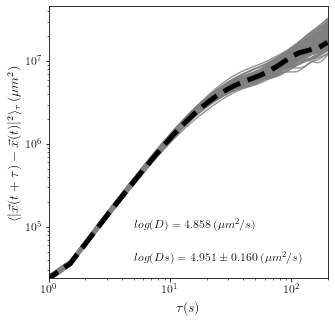

In [28]:
for kw in range(n_worms):
    msd_sims_PF = msd_sims_PF_w[kw]
    mu_data = msd_data_w[kw]
    plt.figure(figsize=(5,5))
    for msd in msd_sims_PF:
        plt.plot(lags*new_dt,msd,c='gray',alpha=.8)
    plt.plot(lags*new_dt,mu_data,lw=5,ls='--',c='k')
    plt.xscale('log')
    plt.yscale('log')
    mean,std = np.mean(np.log10(m_sims_PF_w[kw])),np.std(np.log10(m_sims_PF_w[kw]))
    plt.text(5,4e4,r'$log(Ds) = {:.3f} \pm {:.3f}\,(\mu m^2/s)$'.format(mean,std),fontsize=12)
    plt.text(5,1e5,r'$log(D) = {:.3f} \,(\mu m^2/s)$'.format(np.log10(m_data_w[kw])),fontsize=12)
    plt.xlabel(r'$\tau (s)$',fontsize=14)
    plt.ylabel(r'$\langle|\vec{x}(t+\tau)-\vec{x}(t)|^2\rangle_{\tau}\,(\mu m^2)$',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(1,200)
#     plt.savefig('MSD_PF_sim_w_{}.pdf'.format(kw))
    plt.show()
    

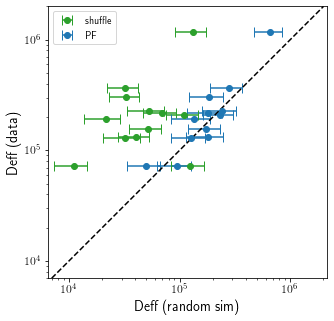

In [29]:
plt.figure(figsize=(5,5))

# err = [np.mean(np.vstack(m_random_w),axis=1)-np.percentile(np.vstack(m_random_w),2.5,axis=1), 
#        np.percentile(np.vstack(m_random_w),97.5,axis=1)-np.mean(np.vstack(m_random_w),axis=1)]
err = np.std(np.vstack(m_sims_random_w),axis=1)
# print(err)
plt.errorbar(np.mean(np.vstack(m_sims_random_w),axis=1),m_data_w,xerr = err,fmt='o',capsize=5,label='shuffle',c=colors_state_[2])
# x0,xf = 1e4,1.4e6
x0,xf = 7e3,2e6
err = np.std(np.vstack(m_sims_PF_w),axis=1)
# err = [np.mean(np.vstack(m_sims_PF_w),axis=1)-np.percentile(np.vstack(m_sims_PF_w),2.5,axis=1), 
#        np.percentile(np.vstack(m_sims_PF_w),97.5,axis=1)-np.mean(np.vstack(m_sims_PF_w),axis=1)]
# print(err)
plt.errorbar(np.mean(np.vstack(m_sims_PF_w),axis=1),m_data_w,xerr = err,fmt='o',capsize=5,label = 'PF')

plt.plot(np.arange(x0,xf,1e2),np.arange(x0,xf,1e2),c='k',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.axis('equal')
plt.xlabel('Deff (random sim)',fontsize=14)
plt.ylabel('Deff (data)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.xlim(x0,xf)
plt.ylim(x0,xf)
# plt.savefig('MDS_sims_onlydata.pdf')

plt.show()
